<a href="https://colab.research.google.com/github/alisdghnia/rnn-lstm-interest-rate-prediction/blob/main/RNN_LSTM_InterestRate_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import io
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM, SimpleRNN, Dropout, Dense, BatchNormalization, Bidirectional, TimeDistributed
from tensorflow.keras.backend import clear_session
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [ ]:
uploaded = files.upload()

Saving DGS10_cleaned.csv to DGS10_cleaned.csv


In [ ]:
ir = pd.read_excel('IR-data.xlsx')
ir = ir.rename(columns={'Interest rate': 'interest_rate'})
ir = ir.set_index('Date')
ir

FileNotFoundError: [Errno 2] No such file or directory: 'IR-data.xlsx'

In [ ]:
ir = pd.read_csv('DGS10_cleaned.csv', index_col=0)
ir.index = pd.to_datetime(ir.index)
ir

,interest_rate
Date,
2007-03-06,4.53
2007-03-07,4.50
2007-03-08,4.51
2007-03-09,4.59
2007-03-12,4.56
...,...
2024-08-29,3.87
2024-08-30,3.91
2024-09-03,3.84


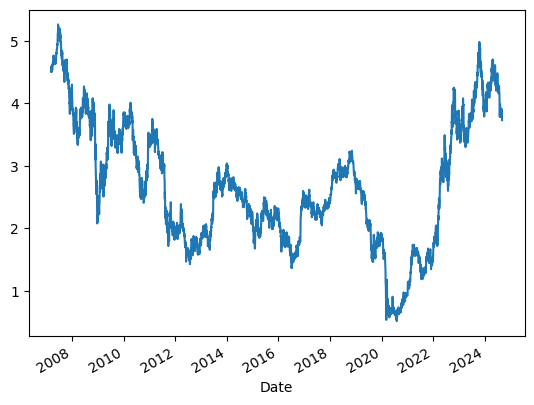

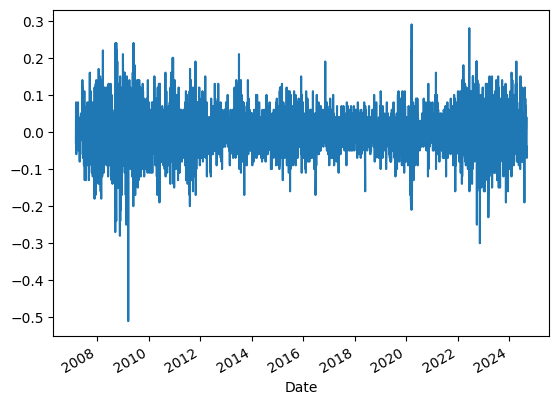

In [ ]:
# check for stationarity
ir['interest_rate'].plot()
plt.show()

ir['interest_rate'].diff().plot()
plt.show()

In [ ]:
# stationarity test
from statsmodels.tsa.stattools import adfuller
result = adfuller(ir['interest_rate'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.119588
p-value: 0.236711
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [ ]:
ir['delta'] = ir['interest_rate'].diff()
ir = ir.dropna()

# stationarity test
result = adfuller(ir['delta'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -49.624696
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Stationarity is visible through first level differencing.
We can use that to train and predict delta values.

In [ ]:
def create_sequences(data, window_size):
    train_window = []
    target_window = []
    for i in range(len(data) - window_size):
        train_window.append(data.iloc[i:i+window_size-1, :])
        target_window.append(data.iloc[i+window_size, :])

    return train_window, target_window

In [ ]:
# build an RNN and use create_sequence function for splitting training and testing data in a for loop

In [ ]:
train = ir.loc[ir.index[ir.index < '2021-01-01'], 'delta']

start_date = pd.to_datetime('2021-01-01') - pd.DateOffset(days=50)
test = ir.loc[ir.index[ir.index >= start_date], 'delta']
# test = ir[ir.index >= '2021-01-01']

train = pd.DataFrame(train)
test = pd.DataFrame(test)

x_train, y_train = create_sequences(train, window_size= 50)
x_test, y_test = create_sequences(test, window_size= 50)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# x_test

((3410, 49, 1), (3410, 1), (905, 49, 1), (905, 1))

# RNN Application

In [ ]:
clear_session()

In [ ]:
window_size = 50
model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0034
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0033
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0032
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0032
Epoch 9/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0032
Epoch 10/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0033
Epoch 11/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0032
Epoch 12/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0031
Epoch 13/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0029
Epoch 14/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031
Epoch 15/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,955 (31.08 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,304 (20.72 KB)

In [86]:
# start with the first sequence from the test data
last_sequence = np.array(test['delta'])[:window_size].reshape(-1, 1)  # reshape to make sure it's 2D

predictions = []

# use the 50 + len(ir[ir.index >= '2021-01-01']) data that we assigned earlier
# to predict for the entire length of the ir[ir.index >= '2021-01-01'] data
for i in range(len(test) - window_size):
    prediction = model.predict(last_sequence.reshape(1, window_size, 1))
    predictions.append(prediction[0, 0])

    # reshape the next value to be appended
    next_value = np.array(test['delta'])[i + window_size].reshape(-1, 1)

    last_sequence = np.append(last_sequence[1:], next_value, axis=0)

print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

In [87]:
ir['predicted_delta'] = np.nan
ir.loc[ir.tail(y_test.shape[0]).index, 'predicted_delta'] = predictions
ir['predicted_interest_rate'] = ir['interest_rate'] + ir['predicted_delta']
ir

<ipython-input-87-c4b31883f651>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ir['predicted_delta'] = np.nan
<ipython-input-87-c4b31883f651>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ir['predicted_interest_rate'] = ir['interest_rate'] + ir['predicted_delta']


,interest_rate,delta,predicted_interest_rate,predicted_delta
Date,,,,
2007-03-07,4.50,-0.03,NaN,NaN
2007-03-08,4.51,0.01,NaN,NaN
2007-03-09,4.59,0.08,NaN,NaN
2007-03-12,4.56,-0.03,NaN,NaN
2007-03-13,4.50,-0.06,NaN,NaN
...,...,...,...,...
2024-08-29,3.87,0.03,3.867125,-0.002875
2024-08-30,3.91,0.04,3.906435,-0.003565
2024-09-03,3.84,-0.07,3.838169,-0.001831


In [88]:
final_df = ir.loc[ir.tail(y_test.shape[0]).index, ['interest_rate', 'predicted_interest_rate']]
final_df = final_df.rename(columns={'interest_rate': 'interest_rate_original', 'predicted_interest_rate': 'interest_rate_rnn'})
final_df

,interest_rate_original,interest_rate_rnn
Date,,
2021-01-27,1.04,1.037778
2021-01-28,1.07,1.068834
2021-01-29,1.11,1.107132
2021-02-01,1.09,1.088617
2021-02-02,1.12,1.119349
...,...,...
2024-08-29,3.87,3.867125
2024-08-30,3.91,3.906435
2024-09-03,3.84,3.838169


In [89]:
rnn_mse = np.mean((final_df['interest_rate_rnn'] - final_df['interest_rate_original'])**2)
rnn_mse

0.0002142786499380175

# LSTM Application

In [ ]:
clear_session()

In [ ]:
window_size = 50
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0033
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0032
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0032
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0032
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0033
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0032
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0032
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0031
Epoch 9/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0032
Epoch 10/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0031
Epoch 11/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0033
Epoch 12/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0032
Epoch 13/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0030
Epoch 14/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0032
Epoch 15/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step 

In [ ]:
# start with the first sequence from the test data
last_sequence = np.array(test['delta'])[:window_size].reshape(-1, 1)  # reshape to make sure it's 2D

lstm_predictions = []

# use the 50 + len(ir[ir.index >= '2021-01-01']) data that we assigned earlier
# to predict for the entire length of the ir[ir.index >= '2021-01-01'] data
for i in range(len(test) - window_size):
    prediction = model.predict(last_sequence.reshape(1, window_size, 1))
    lstm_predictions.append(prediction[0, 0])

    # reshape the next value to be appended
    next_value = np.array(test['delta'])[i + window_size].reshape(-1, 1)

    last_sequence = np.append(last_sequence[1:], next_value, axis=0)

print(lstm_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [ ]:
ir['predicted_delta'] = np.nan
ir.loc[ir.tail(y_test.shape[0]).index, 'predicted_delta'] = lstm_predictions
ir.loc[:, 'predicted_interest_rate'] = ir.loc[:, 'interest_rate'] + ir.loc[:, 'predicted_delta']
final_df['interest_rate_lstm'] = ir.loc[ir.tail(y_test.shape[0]).index, 'predicted_interest_rate']
final_df

<ipython-input-55-bb8b804578cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ir['predicted_delta'] = np.nan


,interest_rate_original,interest_rate_rnn,interest_rate_lstm
Date,,,
2021-01-27,1.04,1.041861,1.039108
2021-01-28,1.07,1.067077,1.069109
2021-01-29,1.11,1.118167,1.109109
2021-02-01,1.09,1.087695,1.089109
2021-02-02,1.12,1.123023,1.119109
...,...,...,...
2024-08-29,3.87,3.874093,3.869095
2024-08-30,3.91,3.913138,3.909099
2024-09-03,3.84,3.838742,3.839101


In [ ]:
lstm_mse = np.mean((final_df['interest_rate_lstm'] - final_df['interest_rate_original'])**2)
rnn_mse = np.mean((final_df['interest_rate_rnn'] - final_df['interest_rate_original'])**2)
lstm_rnn_mse = np.mean((final_df['interest_rate_lstm'] - final_df['interest_rate_rnn'])**2)
print(f'lstm_mse: {lstm_mse}')
print(f'rnn_mse: {rnn_mse}')
print(f'lstm_rnn_mse: {lstm_rnn_mse}')

lstm_mse: 2.5213970375469574e-06
rnn_mse: 0.0002984442085510398
lstm_rnn_mse: 0.0002909931854688689


In [ ]:
lstm_rsquared = 1 - lstm_mse / np.var(final_df['interest_rate_original'])
rnn_rsquared = 1 - rnn_mse / np.var(final_df['interest_rate_original'])

print(f'lstm_rsquared: {lstm_rsquared}')
print(f'rnn_rsquared: {rnn_rsquared}')

lstm_rsquared: 0.9999981288746235
rnn_rsquared: 0.9997785249511341


In [ ]:
clear_session()
# Build an intermediate RNN model
model_intermediate_rnn = Sequential([
    SimpleRNN(100, activation='relu', return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    SimpleRNN(100, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model_intermediate_rnn.compile(optimizer='adam', loss='mse')

# Summary of the model
model_intermediate_rnn.summary()

# Train the model
model_intermediate_rnn.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 50, 100)             │          10,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,401 (138.29 KB)

 Trainable params: 35,401 (138.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.0035 - val_loss: 0.0044
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0031 - val_loss: 0.0044
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 9/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 10/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 11/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 12/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0

In [ ]:
# start with the first sequence from the test data
last_sequence = np.array(test['delta'])[:window_size].reshape(-1, 1)  # reshape to make sure it's 2D

level2_rnn_predictions = []

# use the 50 + len(ir[ir.index >= '2021-01-01']) data that we assigned earlier
# to predict for the entire length of the ir[ir.index >= '2021-01-01'] data
for i in range(len(test) - window_size):
    prediction = model.predict(last_sequence.reshape(1, window_size, 1))
    level2_rnn_predictions.append(prediction[0, 0])

    # reshape the next value to be appended
    next_value = np.array(test['delta'])[i + window_size].reshape(-1, 1)

    last_sequence = np.append(last_sequence[1:], next_value, axis=0)

print(level2_rnn_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━

In [ ]:
ir['predicted_delta'] = np.nan
ir.loc[ir.tail(y_test.shape[0]).index, 'predicted_delta'] = level2_rnn_predictions
ir.loc[:, 'predicted_interest_rate'] = ir.loc[:, 'interest_rate'] + ir.loc[:, 'predicted_delta']
final_df['interest_rate_level2rnn'] = ir.loc[ir.tail(y_test.shape[0]).index, 'predicted_interest_rate']
final_df

<ipython-input-64-6f0fc2843f23>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ir['predicted_delta'] = np.nan


,interest_rate_original,interest_rate_rnn,interest_rate_lstm,interest_rate_level2rnn
Date,,,,
2021-01-27,1.04,1.041861,1.039108,1.039108
2021-01-28,1.07,1.067077,1.069109,1.069109
2021-01-29,1.11,1.118167,1.109109,1.109109
2021-02-01,1.09,1.087695,1.089109,1.089109
2021-02-02,1.12,1.123023,1.119109,1.119109
...,...,...,...,...
2024-08-29,3.87,3.874093,3.869095,3.869095
2024-08-30,3.91,3.913138,3.909099,3.909099
2024-09-03,3.84,3.838742,3.839101,3.839101


In [ ]:
clear_session()
# Build an advanced RNN model
model_advanced_rnn = Sequential([
    Bidirectional(SimpleRNN(100, activation='relu', return_sequences=True, input_shape=(window_size, 1))),
    BatchNormalization(),
    Dropout(0.2),
    Bidirectional(SimpleRNN(100, activation='relu', return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    TimeDistributed(Dense(50, activation='relu')),
    Dense(1)
])

# Compile the model
model_advanced_rnn.compile(optimizer='adam', loss='mse')

# Summary of the model
model_advanced_rnn.summary()

# Train the model
model_advanced_rnn.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - loss: 0.7474 - val_loss: 0.0082
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 353ms/step - loss: 0.1614 - val_loss: 0.0098
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step - loss: 0.0997 - val_loss: 0.0108
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step - loss: 0.0703 - val_loss: 0.0122
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 376ms/step - loss: 0.0517 - val_loss: 0.0109
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 341ms/step - loss: 0.0371 - val_loss: 0.0107
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step - loss: 0.0246 - val_loss: 0.0099
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 326ms/step - loss: 0.0170 - val_loss: 0.0088
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - loss: 0.0120 - val_loss: 0.0069
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - loss: 0.0096 - val_loss: 0.0077
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 334m

In [ ]:
# start with the first sequence from the test data
last_sequence = np.array(test['delta'])[:window_size].reshape(-1, 1)  # reshape to make sure it's 2D

level3_rnn_predictions = []

# use the 50 + len(ir[ir.index >= '2021-01-01']) data that we assigned earlier
# to predict for the entire length of the ir[ir.index >= '2021-01-01'] data
for i in range(len(test) - window_size):
    prediction = model.predict(last_sequence.reshape(1, window_size, 1))
    level3_rnn_predictions.append(prediction[0, 0])

    # reshape the next value to be appended
    next_value = np.array(test['delta'])[i + window_size].reshape(-1, 1)

    last_sequence = np.append(last_sequence[1:], next_value, axis=0)

print(level3_rnn_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

In [ ]:
ir['predicted_delta'] = np.nan
ir.loc[ir.tail(y_test.shape[0]).index, 'predicted_delta'] = level3_rnn_predictions
ir.loc[:, 'predicted_interest_rate'] = ir.loc[:, 'interest_rate'] + ir.loc[:, 'predicted_delta']
final_df['interest_rate_level3rnn'] = ir.loc[ir.tail(y_test.shape[0]).index, 'predicted_interest_rate']
final_df

<ipython-input-67-f6f50c7fde4f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ir['predicted_delta'] = np.nan


,interest_rate_original,interest_rate_rnn,interest_rate_lstm,interest_rate_level2rnn,interest_rate_level3rnn
Date,,,,,
2021-01-27,1.04,1.041861,1.039108,1.039108,1.039108
2021-01-28,1.07,1.067077,1.069109,1.069109,1.069109
2021-01-29,1.11,1.118167,1.109109,1.109109,1.109109
2021-02-01,1.09,1.087695,1.089109,1.089109,1.089109
2021-02-02,1.12,1.123023,1.119109,1.119109,1.119109
...,...,...,...,...,...
2024-08-29,3.87,3.874093,3.869095,3.869095,3.869095
2024-08-30,3.91,3.913138,3.909099,3.909099,3.909099
2024-09-03,3.84,3.838742,3.839101,3.839101,3.839101


In [ ]:
clear_session()

In [ ]:
model_intermediate = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

model_intermediate.compile(optimizer='adam', loss='mse')
model_intermediate.summary()
model_intermediate.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,301 (493.36 KB)

 Trainable params: 126,301 (493.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - loss: 0.0032 - val_loss: 0.0045
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 9/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 10/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 191ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 11/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 12/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 158m

In [ ]:
# start with the first sequence from the test data
last_sequence = np.array(test['delta'])[:window_size].reshape(-1, 1)  # reshape to make sure it's 2D

level2_lstm_predictions = []

# use the 50 + len(ir[ir.index >= '2021-01-01']) data that we assigned earlier
# to predict for the entire length of the ir[ir.index >= '2021-01-01'] data
for i in range(len(test) - window_size):
    prediction = model.predict(last_sequence.reshape(1, window_size, 1))
    level2_lstm_predictions.append(prediction[0, 0])

    # reshape the next value to be appended
    next_value = np.array(test['delta'])[i + window_size].reshape(-1, 1)

    last_sequence = np.append(last_sequence[1:], next_value, axis=0)

print(level2_lstm_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [ ]:
ir['predicted_delta'] = np.nan
ir.loc[ir.tail(y_test.shape[0]).index, 'predicted_delta'] = level2_lstm_predictions
ir.loc[:, 'predicted_interest_rate'] = ir.loc[:, 'interest_rate'] + ir.loc[:, 'predicted_delta']
final_df['interest_rate_level2lstm'] = ir.loc[ir.tail(y_test.shape[0]).index, 'predicted_interest_rate']
final_df

<ipython-input-74-dd384d072563>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ir['predicted_delta'] = np.nan


,interest_rate_original,interest_rate_rnn,interest_rate_lstm,interest_rate_level2rnn,interest_rate_level3rnn,interest_rate_level2lstm
Date,,,,,,
2021-01-27,1.04,1.041861,1.039108,1.039108,1.039108,1.039108
2021-01-28,1.07,1.067077,1.069109,1.069109,1.069109,1.069109
2021-01-29,1.11,1.118167,1.109109,1.109109,1.109109,1.109109
2021-02-01,1.09,1.087695,1.089109,1.089109,1.089109,1.089109
2021-02-02,1.12,1.123023,1.119109,1.119109,1.119109,1.119109
...,...,...,...,...,...,...
2024-08-29,3.87,3.874093,3.869095,3.869095,3.869095,3.869095
2024-08-30,3.91,3.913138,3.909099,3.909099,3.909099,3.909099
2024-09-03,3.84,3.838742,3.839101,3.839101,3.839101,3.839101


In [ ]:
clear_session()
model_advanced = Sequential([
    Bidirectional(LSTM(100, activation='relu', return_sequences=True, input_shape=(window_size, 1))),
    BatchNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(100, activation='relu', return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    TimeDistributed(Dense(50, activation='relu')),
    Dense(1)
])

model_advanced.compile(optimizer='adam', loss='mse')
model_advanced.summary()
model_advanced.fit(x_train, y_train, epochs=50, batch_size=128, validation_data=(x_test, y_test))

In [ ]:
# start with the first sequence from the test data
last_sequence = np.array(test['delta'])[:window_size].reshape(-1, 1)  # reshape to make sure it's 2D

level3_lstm_predictions = []

# use the 50 + len(ir[ir.index >= '2021-01-01']) data that we assigned earlier
# to predict for the entire length of the ir[ir.index >= '2021-01-01'] data
for i in range(len(test) - window_size):
    prediction = model.predict(last_sequence.reshape(1, window_size, 1))
    level3_lstm_predictions.append(prediction[0, 0])

    # reshape the next value to be appended
    next_value = np.array(test['delta'])[i + window_size].reshape(-1, 1)

    last_sequence = np.append(last_sequence[1:], next_value, axis=0)

print(level3_lstm_predictions)

In [ ]:
ir['predicted_delta'] = np.nan
ir.loc[ir.tail(y_test.shape[0]).index, 'predicted_delta'] = level3_lstm_predictions
ir.loc[:, 'predicted_interest_rate'] = ir.loc[:, 'interest_rate'] + ir.loc[:, 'predicted_delta']
final_df['interest_rate_level3lstm'] = ir.loc[ir.tail(y_test.shape[0]).index, 'predicted_interest_rate']
final_df

In [ ]:
final_df.loc[:, 'interest_rate_level2_rnn'] = level2_rnn_predictions
final_df.loc[:, 'interest_rate_level3_rnn'] = level3_rnn_predictions
final_df.loc[:, 'interest_rate_level2_lstm'] = level2_lstm_predictions
final_df.loc[:, 'interest_rate_level3_lstm'] = level3_lstm_predictions
final_df

,interest_rate_original,interest_rate_rnn,interest_rate_lstm,interest_rate_level2_rnn,interest_rate_level3_rnn,interest_rate_level2_lstm,interest_rate_level3_lstm
Date,,,,,,,
2021-03-17,1.63,1.633905,1.615261,1.615261,1.615261,1.615261,1.615261
2021-03-18,1.71,1.627794,1.627887,1.627887,1.627887,1.627887,1.627887
2021-03-19,1.74,1.658814,1.659961,1.659961,1.659961,1.659961,1.659961
2021-03-22,1.69,1.710783,1.690779,1.690779,1.690779,1.690779,1.690779
2021-03-23,1.63,1.728193,1.699072,1.699072,1.699072,1.699072,1.699072
...,...,...,...,...,...,...,...
2024-08-29,3.87,3.825489,3.846483,3.846483,3.846483,3.846483,3.846483
2024-08-30,3.91,3.840465,3.868159,3.868159,3.868159,3.868159,3.868159
2024-09-03,3.84,3.870389,3.901559,3.901559,3.901559,3.901559,3.901559


In [ ]:
level2_rnn_mse = np.mean((final_df['interest_rate_level2_rnn'] - final_df['interest_rate_original'])**2)
level3_rnn_mse = np.mean((final_df['interest_rate_level3_rnn'] - final_df['interest_rate_original'])**2)
level2_lstm_mse = np.mean((final_df['interest_rate_level2_lstm'] - final_df['interest_rate_original'])**2)
level3_lstm_mse = np.mean((final_df['interest_rate_level3_lstm'] - final_df['interest_rate_original'])**2)
print(f'level2_rnn_mse: {level2_rnn_mse}')
print(f'level3_rnn_mse: {level3_rnn_mse}')
print(f'level2_lstm_mse: {level2_lstm_mse}')
print(f'level3_lstm_mse: {level3_lstm_mse}')

level2_rnn_mse: 0.005778612271985724
level3_rnn_mse: 0.005778612271985724
level2_lstm_mse: 0.005778612271985724
level3_lstm_mse: 0.005778612271985724
